In [85]:
from IPython.display import display, HTML
display(HTML("""<style>.container { width:90% !important; }.text_cell_render, .output_text {font-family: Lato;font-size: 18px;line-height: 1.5;}.CodeMirror {font-size: 16px;}</style>"""))
from quiz.jupyterquiz import display_quiz

# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 3

In [2]:
# try:
#     import google.colab
#     import requests
#     url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
#     r = requests.get(url, allow_redirects=True)
#     open('config.py', 'wb').write(r.content)    
# except ModuleNotFoundError:
#     pass

# from config import *
# config_chapter3()
# # This is needed to render the plots in this chapter
# from plots.chapter3 import *

In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

#from stepbystep.v0 import StepByStep
from plots.chapter3 import *

# A Simple Classification Problem

It is time to handle a different **class** of problems: **classification problems** (pun intended). In a classification problem, we're trying to predict **which class a data point belongs to**. 

Let's say we have **two classes** of points: They are either **red** or **blue**. These are the **labels (_y_)** of the points. Sure enough, we need to assign **numeric values** to them. We could assign **zero** to **red** and **one** to **blue**. The class associated with **zero** is the **negative class**, while **one** corresponds to the **positive class**.

In a nutshell, for **binary classification**, we have:

| Color | Value |  Class
|:--:|:--:|:--
|  Red  |   0   | Negative
| Blue  |   1   | Positive

**IMPORTANT**: In a classification model, the **output** is the predicted probability of the **positive class**. In our case, the model will predict the _probability of a point being blue_. 

The choice of _which class is positive_ and _which class is negative_ **does not** affect model performance. If we reverse the mapping, making _red the positive class_, the only difference would be that the model would predict the _probability of a point being red_. But, since **both probabilities have to add up to one**, we could easily convert between them, so the **models are equivalent**.

Instead of defining a model first and _then_ generating synthetic data for it, we'll do it **the other way around**.

## Data Generation

In [2]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

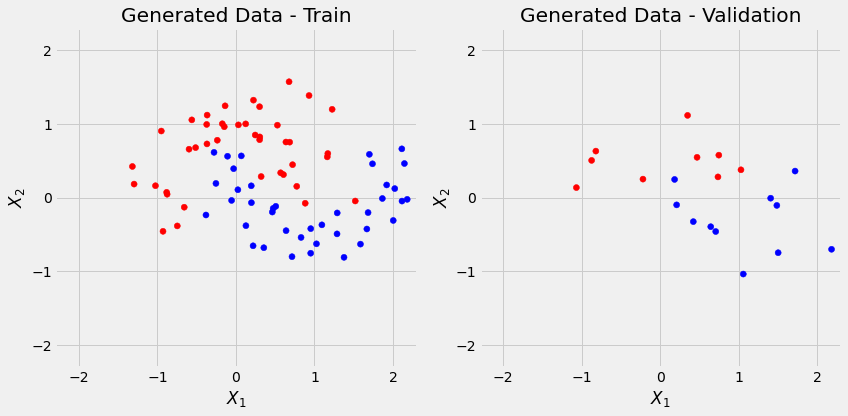

In [3]:
fig = figure1(X_train, y_train, X_val, y_val)

In [4]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

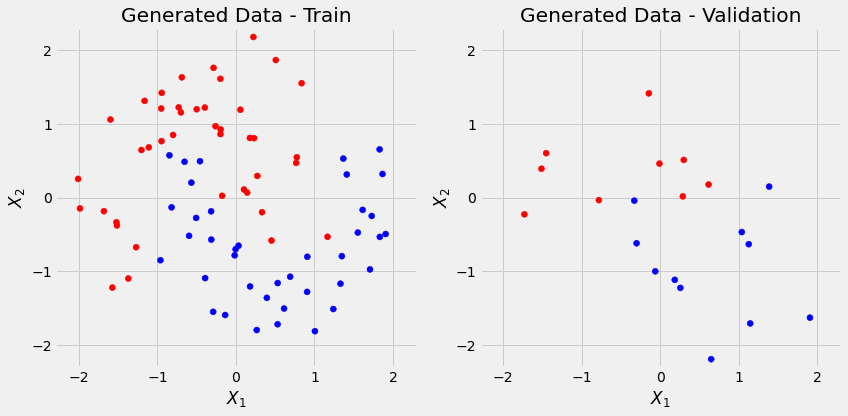

In [5]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

In [6]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=20)

## Model

Given a **classification problem**, one of the more straightforward models is the **logistic regression**. But, instead of simply _presenting_ it and using it right away, I am going to **build up to it**. The rationale behind this approach is twofold: First, it will make clear why this algorithm is called logistic _regression_ if it is used for classification; second, you'll get a **clear understanding of what a _logit_ is**.

Well, since it is called logistic **regression**, I would say that **linear regression** is a good starting point. What would a linear regression model with two features look like?

$$
\Large
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

There is one obvious **problem** with the model above: Our **labels (_y_)** are **discrete**; that is, they are either **zero** or **one**; no other value is allowed. We need to **change the model slightly** to adapt it to our purposes.

"_What if we assign the **positive** outputs to **one** and the **negative** outputs to **zero**?_"

Makes sense, right? We're already calling them **positive** and **negative** classes anyway; why not put their names to good use? Our model would look like this:

$$
\Large 
y =
\begin{cases}
1,\ \text{if }b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ \text{if }b + w_1x_1 + w_2x_2 < 0
\end{cases}
$$

### Logits

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

The equation above is strikingly similar to the original **linear regression model**, but we're calling the resulting value *_z_*, or **logit**, instead of *_y_*, or **label**.

"_Does it mean a **logit** is the same as **linear regression**?_"

Not quite—there is one **fundamental difference** between them: There is **no error term (_epsilon_)**!

"_If there is no error term, where does the **uncertainty** come from?_"

I am glad you asked :-)  That's the role of the **probability**: Instead of assigning a data point to a **discrete label (zero or one)**, we'll compute the **probability of a data point's belonging to the positive class**.

### Probabilities

If a data point has a **logit** that equals **zero**, it is exactly at the decision boundary since it is neither positive nor negative. For the sake of completeness, we assigned it to the **positive class**, but this assignment has **maximum uncertainty**, right? So, the corresponding **probability needs to be 0.5** (50%), since it could go either way.

Following this reasoning, we would like to have **large _positive_ logit values** assigned to **_higher_ probabilities** (of being in the positive class) and **large _negative_ logit values** assigned to *_lower probabilities_* (of being in the positive class).

For _really large_ positive and negative **logit values (_z_)**, we would like to have:

$$
\Large
\begin{aligned}
& \text{P}(y=1) \approx 1.0, & \text{if } &z \gg 0
\\
& \text{P}(y=1) = 0.5, & \text{if } &z = 0
\\
& \text{P}(y=1) \approx 0.0, & \text{if } &z \ll 0
\end{aligned}
$$

### Odds Ratio

"_What are the odds?!_"

This is a colloquial expression meaning something very unlikely has happened. But **odds** do not have to refer to an unlikely event or a slim chance. The odds of getting **heads** in a (fair) coin flip are 1 to 1 since there is a 50% chance of success and a 50% chance of failure.

Let's imagine we are betting on the winner of the World Cup final. There are two countries: **A** and **B**. Country **A** is the **favorite**: It has a 75% chance of winning. So, Country **B** has only a 25% chance of winning. If you bet on Country **A**, your chances of winning—that is, your **odds (in favor)**—are **3 to 1** (75 to 25). If you decide to test your luck and bet on Country **B**, your chances of winning—that is, your **odds (in favor)**—are **1 to 3** (25 to 75), or **0.33 to 1**.

The **odds ratio** is given by the **ratio** between the **probability of success** (_p_) and the **probability of failure** (_q_):


$$
\Large \text{odds ratio }(p) = \frac{p}{q} = \frac{p}{1-p}
$$

In [9]:
def odds_ratio(prob):
    return prob / (1 - prob)

In [10]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

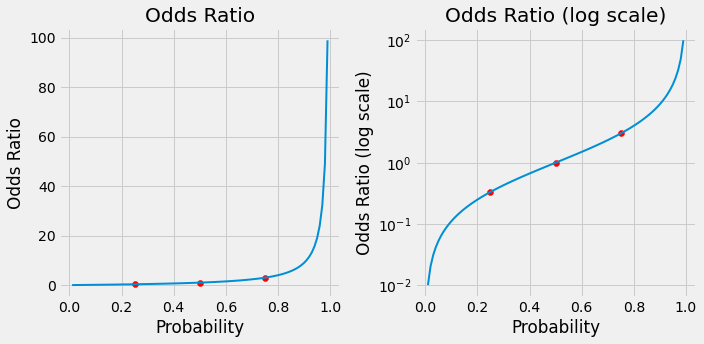

In [11]:
fig = figure2(p)

Clearly, the odds ratios (left plot) are **not symmetrical**. But, in a **log scale** (right plot), **they are**. This serves us very well since we're looking for a **symmetrical function** that maps **logit values** into **probabilities**.

"_Why does it **need** to be **symmetrical**?_"

If the function **weren't** symmetrical, different choices for the **positive class** would produce models that were **not** equivalent. But, using a symmetrical function, we could train **two equivalent models** using the **same dataset**, just flipping the classes:

* **Blue Model** (the positive class (_y=1_) corresponds to **blue** points)
** Data Point #1: **P(_y=1_) = P(blue) = .83** (which is the same as *P(red) = .17*)
* **Red Model** (the positive class (_y=1_) corresponds to **red** points)
** Data Point #1: **P(_y=1_) = P(red) = .17** (which is the same as *P(blue) = .83*)

### Log Odds Ratio

By taking the **logarithm** of the **odds ratio**, the function is not only **symmetrical**, but also maps **probabilities** into **real numbers**, instead of only the positive ones: 

$$
\Large \text{log odds ratio }(p) = \text{log}\left(\frac{p}{1-p}\right)
$$

In [12]:
def log_odds_ratio(prob):
    return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

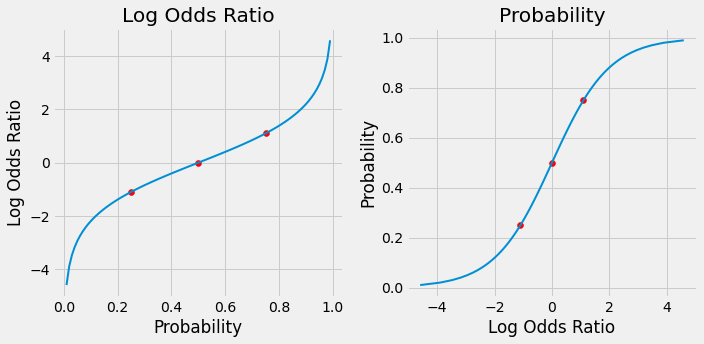

In [13]:
fig = figure3(p)

On the left, **each probability maps into a log odds ratio**. The _red dots_ correspond to probabilities of 25%, 50%, and 75%, the same as before.

If we **flip** the horizontal and vertical axes (right plot), we are **inverting the function**, thus mapping **each log odds ratio into a probability**. That's the function we were looking for!

Does its shape look familiar? Wait for it...

### From Logits to Probabilities

In the previous section, we were trying to **map logit values into probabilities**, and we've just found out, graphically, a function that **maps log odds ratios into probabilities**. 

Clearly, our **logits are log odds ratios** :-) Sure, drawing conclusions like this is not very scientific, but the purpose of this exercise is to illustrate how the results of a regression, represented by the *logits (z)*, get to be mapped into probabilities.

$$
\Large
\begin{aligned}
b + w_1x_1 + w_2x_2 = &\ z = \text{log}\left(\frac{p}{1-p}\right) \nonumber
\\
e^{b + w_1x_1 + w_2x_2} = &\ e^z = \frac{p}{1-p} \nonumber
\end{aligned}
$$

$$
\Large
\begin{aligned}
\frac{1}{e^z}& = \frac{1-p}{p}
\\
e^{-z}& = \frac{1}{p} - 1
\\
1 + e^{-z}& = \frac{1}{p}&
\\
p& = \frac{1}{1 + e^{-z}}
\end{aligned}
$$

$$
\Large
p = \sigma(z) = \frac{1}{1+e^{-z}}
$$

Does it look familiar? That's a **sigmoid function**! It is the **inverse of the log odds ratio**.

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

### Sigmoid

There is no need to implement our own sigmoid function, though. PyTorch provides two different ways of using a **sigmoid**: [`torch.sigmoid()`](https://pytorch.org/docs/master/generated/torch.sigmoid.html) and [`nn.Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html). 

The first one is a simple **function**, like the one above, but takes a tensor as input and returns another tensor:

In [15]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

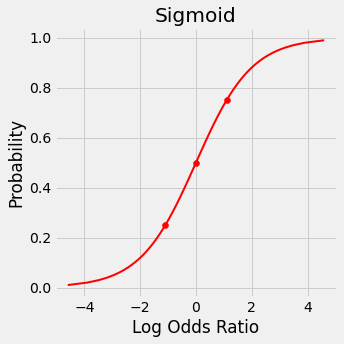

In [16]:
fig = figure4(p)

The second one is a full-fledged **class** inherited from `nn.Module`. It is, for all intents and purposes, a **model on its own**. It is quite a simple and straightforward model: It **only** implements a `forward()` method, which, surprise, surprise, calls `torch.sigmoid()`.

"_Why do you need a **model** for a **sigmoid** function?_"

Remember, models can be used as **layers** of another, larger model. That's exactly what we're going to do with the **sigmoid class**.

### Logistic Regression

Given **two features**, **_x~1~_** and **_x~2~_**, the model will fit a **linear regression** such that its outputs are **logits (_z_)**, which are then converted into **probabilities** using a **sigmoid function**.

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

![](images/logistic_model.png)

In [17]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


We can think of the **logistic regression** as the **second simplest neural network possible**. It is pretty much the **same as the linear regression**, but with a **sigmoid** applied to the results of the output layer (_z_).

### Sigmoid, nonlinearities, and activation functions

The sigmoid function is **nonlinear**. It can be used to map **logits** into **probabilities**, as we've just figured out. But this **is not** its only purpose!

**Nonlinear functions play a fundamental role** in neural networks. We know these nonlinearities by their usual name: **activation functions**. 

The sigmoid is the "biologically-inspired" and first activation function to be used back in the old days. It was followed by the hyperbolic-tangent (TanH) and, more recently, by the rectified linear unit (ReLU) and the whole family of functions it spawned.

Moreover, there would be **no neural networks without a nonlinear function.** Have you ever wondered _what would happen to a neural network_, no matter how many layers deep, **if all its activation functions were removed**?

The network would be **equivalent to linear regression**. True story!

### A Note on Notation

$$
\Large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

$$
\Large 
\begin{aligned}
z
& = W^T X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

## Loss

We already have a model, and now we need to define an appropriate **loss** for it. A **binary classification** problem calls for the **binary cross-entropy (BCE) loss**, sometimes known as **log loss**.

The **BCE loss** requires the **predicted probabilities**, as returned by the **sigmoid function**, and the **true labels (_y_)** for its computation. For each data point *_i_* in the training set, it starts by computing the **error** corresponding to the point's **true class**.

If the data point belongs to the **positive class (_y=1_)**, we would like our model to **predict a probability close to one**, right? A **perfect one** would result in the **logarithm of one**, which is **zero**. It makes sense; **a perfect prediction means zero loss**. It goes like this:

$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

What if the data point belongs to the **negative class (_y=0_)**? Then we **cannot** simply use the predicted probability. Why not? Because the model outputs the probability of a point's belonging to the _positive_, not the _negative_, class. Luckily, the latter can be easily computed:

$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

And thus, the **error** associated with a data point's belonging to the **negative class** goes like this:

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

Once all errors are computed, they are **aggregated into a loss value**. For the binary-cross entropy loss, we simply take the **average of the errors** and **invert its sign**.

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

Let's assume we have two dummy data points, one for each class. Then, let's pretend our model made predictions for them: 0.9 and 0.2. The predictions are not bad since it predicts a 90% probability of being positive for an actual positive, and only 20% of being positive for an actual negative. How does this look in code? Here it is:

In [18]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Positive class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]
first_summation = torch.log(positive_pred).sum()
# Negative class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
second_summation = torch.log(1 - negative_pred).sum()
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)

loss = -(first_summation + second_summation) / n_total
loss

tensor(0.1643)

The first summation adds up the errors corresponding to the points in the positive class. The second summation adds up the errors corresponding to the points in the negative class. I believe the **formula above** is quite **straightforward** and **easy to understand**. Unfortunately, it is usually _skipped_ over, and only its equivalent is presented:

$$
\Large
\text{BCE}(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \text{log}(\text{P}(y_i=1)) + (1-y_i) \text{log}(1-\text{P}(y_i=1))\right]}}
$$

The formula above is a _clever way_ of computing the loss in a single expression, sure, but the split of positive and negative points is less obvious. If you pause for a minute, you'll realize that points in the **positive class (_y=1_)** have their **second term equal zero**, while points in the **negative class (_y=0_)** have their **first term equal zero**.

Let's see how it looks in code:

In [19]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)
)
loss = -summation / n_total
loss

tensor(0.1643)

Of course, we got the same loss (0.1643) as before.

For a _very_ detailed explanation of the rationale behind this loss function, make sure to check my post: ["Understanding binary cross-entropy / log loss: a visual explanation."](https://bit.ly/2GlmLO0)


### BCELoss

Sure enough, PyTorch implements the _binary cross-entropy loss_, [`nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). Just like its regression counterpart, `nn.MSELoss()`, it is a _higher-order function_ that **returns the actual loss function**.

The **`nn.BCELoss()`** higher-order function takes two **optional** arguments (the others are deprecated, and you can safely ignore them):

- `reduction`: It takes either  `mean`, `sum`, or `none`. The default **`mean`** corresponds to the equation above. As expected, `sum` will return the sum of the errors, instead of the average. The last option, **`none`**, corresponds to the **unreduced** form; that is, it returns the full **array of errors**.

- `weight`: The default is `none`, meaning every data point has equal weight. If supplied, it needs to be a tensor with a size equal to the number of elements in a mini-batch, representing the weights assigned to each element in the batch. In other words, this argument allows you to assign different weights to each element of the current batch, based on its position. So, the **first element** would have a given weight, the **second element** would have a different weight, and so on, **regardless of the actual class of that particular data point**. Sounds confusing? Weird? Yes, this is weird; I think so too. Of course, this is not useless or a mistake, but the proper usage of this argument is a more advanced topic and outside the scope of this book.

This argument **DOES NOT help with weighting imbalanced datasets**! We'll see how to handle that shortly.

In [20]:
loss_fn = nn.BCELoss(reduction='mean')

loss_fn

BCELoss()

As expected, `nn.BCELoss()` returned another function; that is, the actual loss function. The latter takes both predictions and labels to compute the loss.

**IMPORTANT**: Make sure to pass the **predictions first** and then the **labels** to the loss function. The **order matters** in the implementation of this loss function, unlike with the mean squared error.

Let's check this out:

In [21]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


Clearly, the order matters. It matters because the `nn.BCELoss()` takes the logarithm of the probabilities, which is expected as the **first argument**. If we swap the arguments, it will yield different results. In Chapter 1, we followed the same convention when using `nn.MSELoss()` — **first predictions**, **then labels** — even though it wouldn't make any difference there.

So far, so good. But there is yet **another** binary cross-entropy loss available, and it is **very important** to know **when to use one or the other**, so you don't end up with an inconsistent combination of model and loss function. Moreover, you'll understand why I made such a fuss about the **logits**.

### BCEWithLogitsLoss

The former loss function took probabilities as an argument (together with the labels, obviously). This loss function takes **logits** as an argument, instead of probabilities.

"_What does that mean, in practical terms?_"

It means you **should NOT add a sigmoid as the last layer of your model** when using this loss function. This loss combines both the **sigmoid layer and the former binary cross-entropy loss into one**.

**IMPORTANT**: I can't stress this enough: You **must** use the **right combination of model and loss function**.

- **Option 1**: `nn.Sigmoid` as the **last** layer, meaning your model is producing **probabilities**, combined with the `nn.BCELoss()` function.

- **Option 2**: **No sigmoid** in the last layer, meaning your model is producing **logits**, combined with the `nn.BCEWithLogitsLoss()` function.

Mixing `nn.Sigmoid` and `nn.BCEWithLogitsLoss()` is just **wrong**.

Besides, **Option 2 is preferred** since it is numerically more stable than Option 1.

Now, let's take a closer look at the [`nn.BCEWithLogitsLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) function. It is also a higher-order function, but it takes three **optional** arguments (the others are deprecated, and you can safely ignore them):

- `reduction`: It takes either  `mean`, `sum`, or `none`, and it works just like in `nn.BCELoss()`. The default is **`mean`**. 

- `weight`: This argument also works just like in `nn.BCELoss()`, and it is unlikely to be used.

- `pos_weight`: The weight of positive samples, it must be a tensor with length equal to the **number of labels associated with a data point** (the documentation refers to _classes_, instead of labels, which just makes everything even more confusing). 

To make it clear: In this chapter, we're dealing with a **single-label binary classification** (we have only **one label** per data point), and the **label is binary** (there are only two possible values for it, zero or one). If the label is **zero**, we say it belongs to the **negative class**. If the label is **one**, it belongs to the **positive class**.

Please do not confuse the positive and negative classes of our single label with *_c_*, the so-called **class number** in the documentation. That *_c_* corresponds to the **number of different labels associated with a data point**. In our example, **_c_ = 1**.

You _can_ use this argument to handle **imbalanced datasets**, but there's more to it than meets the eye. We'll get back to it in the next sub-section.

Enough talking (or writing!): Let's see how to use this loss in code. We start by creating the loss function itself:

In [23]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

Next, we use **logits** and **labels** to compute the loss. Following the same principle as before, **logits first**, **then labels**. To keep the example consistent, let's get the values of the logits corresponding to the probabilities we used before, 0.9 and 0.2, using our `+log_odds_ratio()+` function:

In [24]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [25]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

### Imbalanced Dataset

In our dummy example with two data points, we had one of each class: positive and negative. The dataset was perfectly balanced. Let's create another dummy example but with an imbalance, adding **two extra data points belonging to the negative class**. For the sake of simplicity and to illustrate a _quirk_ in the behavior of `+nn.BCEWithLogitsLoss()+`, I will give those two extra points the **same logits** as the other data point in the negative class. It looks like this:

In [26]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

Clearly, this is an **imbalanced dataset**. There are **three times more** data points in the negative class than in the positive one. Now, let's turn to the `pos_weight` argument of `nn.BCEWithLogitsLoss()`. To compensate for the imbalance, one can set the weight to equal the ratio of negative to positive examples:

$$
\Large \text{pos_weight} = \frac{\text{# points in negative class}}{\text{# points in positive class}}
$$

In our imbalanced dummy example, the result would be 3.0. This way, every point in the _positive class_ would have its corresponding **loss multiplied by three**. Since there is a **single label** for each data point (_c_ = 1), the **tensor used as an argument for `pos_weight`** has only **one element**: `tensor([3.0])`. We could compute it like this:


In [28]:
n_neg = (dummy_imb_labels == 0).sum().float()
n_pos = (dummy_imb_labels == 1).sum().float()

pos_weight = (n_neg / n_pos).view(1,)
pos_weight

tensor([3.])

Now, let's create yet another loss function, including the `pos_weight` argument this time:

In [29]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

Then, we can use this **weighted** loss function to compute the loss for our **imbalanced dataset**. I guess one would expect the **same loss** as before; after all, this is a _weighted_ loss. Right?

In [30]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

Wrong! It was 0.1643 when we had two data points, one of each class. Now it is 0.2464, **even though we assigned a weight** to the positive class.

"_Why is it different?_"

Well, it turns out, PyTorch **does not compute a weighted average**. Here's what you would expect from a weighted average:

$$
\Large \text{weighted average} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{\text{pos_weight} N_{\text{pos}}+N_{\text{neg}}}
$$

$$
\Large \text{BCEWithLogitsLoss} = \frac{\text{pos_weight} \sum_{i=1}^{N_{\text{pos}}}{\text{loss}_i}+\sum_{i=1}^{N_{\text{neg}}}{\text{loss}_i}}{N_{\text{pos}}+N_{\text{neg}}}
$$

See the difference in the denominator? Of course, if you **multiply the losses** of the positive examples **without multiplying their count (_N~pos~_)**, you'll end up with a number **larger than an actual weighted average**.

"_What if I **really** want the weighted average?_"

It is not that hard, to be honest. Remember the `reduction` argument? If we set it to `sum`, our loss function will only return the **numerator** of the equation above. And then we can divide it by the weighted counts ourselves:


In [31]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration

In [32]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))
2
# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

## Model Training

In [54]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

In [55]:
fig = sbs.plot_losses()

In [56]:
print(model.state_dict())

Our model produced **logits**, right? So we can plug the weights above into the corresponding **logit equation**, and end up with:

$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0587 & + & 1.1822x_1 & - & 1.8684x_2
\end{array}
$$

The value *_z_* above is the **output of our model**. It is a "_glorified_ linear regression!" And this is a classification problem! How come?! Hold that thought; it will become more clear in the next section, "Decision Boundary".

But, before going down that road, I would like to use our model to **make predictions** for, say, the first four data points in our training set:

#### Making Predictions (Logits)

Clearly, these are not probabilities, right? These are **logits**, as expected.

We can still get the corresponding probabilities, though.

"_How do we go from logits to probabilities_," you ask, just to make sure you got it right.

That's what the **sigmoid function** is good for.

In [44]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

#### Making Predictions (Probabilities)

In [45]:
probabilities = sigmoid(predictions[:4])
probabilities

array([[0.40745783],
       [0.6769154 ],
       [0.07041688],
       [0.2818984 ]], dtype=float32)

Now we're talking! These are the **probabilities**, given our model, of those four points being positive examples.

#### Making Predictions (Classes)

Lastly, we need to go from probabilities to classes. If the **probability is greater than or equal to a threshold**, it is a **positive** example. If it is **less than the threshold**, it is a **negative** example. Simple enough. The trivial choice of a **threshold** is **0.5**:

$$
\Large y =
\begin{cases}
1,\ \text{if P}(y=1) \ge 0.5
\\
0,\ \text{if P}(y=1) < 0.5
\end{cases}
$$

But the probability itself is just the **sigmoid** function applied to the **logit (_z_)**:

$$
\Large y =
\begin{cases}
1,\ \text{if } \sigma(z) \ge 0.5
\\
0,\ \text{if } \sigma(z) < 0.5
\end{cases}
$$

But the **sigmoid** function has a value of **0.5** only when the **logit (_z_)** has a value of **zero**:

$$
\Large y =
\begin{cases}
1,\ \text{if } z \ge 0
\\
0,\ \text{if } z < 0
\end{cases}
$$

Thus, if we don't care about the probabilities, we could use the **predictions (logits)** directly to get the **predicted classes** for the data points:

In [46]:
classes = (predictions[:4] >= 0).astype(int)
classes

array([[0],
       [1],
       [0],
       [0]])

Clearly, the points where the **logits (_z_) equal zero** determine the **boundary** between **positive** and **negative** examples.

"_Why 0.5? Can I choose a **different threshold**?_"

Sure, you can! **Different thresholds** will give you **different confusion matrices** and, therefore, **different metrics**, like accuracy, precision, and recall. We'll get back to that in the "Decision Boundary" section.

By the way, are you still _holding that thought_ about the "_glorified linear regression?_" Good!

## Decision Boundary

We have just figured out that whenever **_z_ equals zero**, we are in the **decision boundary**. But *_z_* is given by a **linear combination** of features **_x~1~_** and **_x~2~_**. If we work out some basic operations, we arrive at:

$$
\Large
\begin{array}{ccccccccc}
z & = &   0 & =   & b & + & w_1x_1 & + & w_2x_2
\\
& & -w_2x_2 & = & b & + & w_1x_1 & &
\\
& & x_2 & = & -\frac{b}{w_2} & - &\frac{w_1}{w_2}x_1 & &
\end{array}
$$

Given our model (*_b_*, **_w~1~_**, and **_w~2~_**), for any value of the first feature (**_x~1~_**), we can compute the corresponding value of the second feature (**_x~2~_**) that sits **exactly at the decision boundary**.

Look at the expression in the equation above: This is a **straight line**. It means the **decision boundary is a straight line**.

Let's plug the **weights** of our **trained model** into it:

$$
\Large
\begin{array}{ccccccccc}
& & x_2 & = & -\frac{0.0587}{1.8684} & + &\frac{1.1822}{1.8684}x_1 & &
\\
& & x_2 & = & -0.0314 & + &0.6327x_1 & &
\end{array}
$$

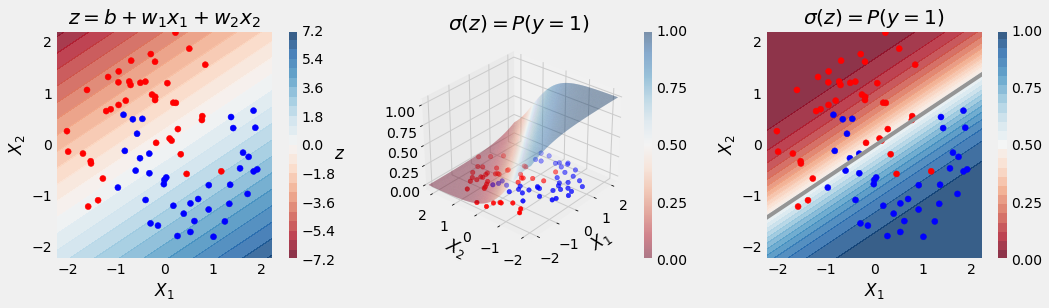

In [48]:
# Training set
fig = figure7(X_train, y_train, pl_model.model, 'cpu')

The figure above tells the whole story! It contains only **data points** from the **training set**. So, that's what the model "sees" when it is training. It will try to achieve the **best possible separation** between the two classes, depicted as **red** (negative class) and **blue** (positive class) points.

In the left plot, we have a **contour plot** (remember those from the loss surfaces in Chapter 0?) of the **logits (_z_)**. 

In the center plot, we have a 3D plot of the **probabilities** resulting from **applying a sigmoid function** to the logits. You can even see the **shape** of the sigmoid function in 3D, approaching zero to the left and one to the right.

Finally, in the right plot, we have a **contour plot** of the **probabilities**, so it is the same as the center plot but without the cool 3D effect. Maybe it is not as cool, but it is surely easier to understand. **Darker blue (red) colors** mean **higher (lower) probabilities**, and we have the **decision boundary as a straight gray line**, corresponding to a **probability of 50%** (and a logit value of zero).

---

**A logistic regression always separates two classes with a straight line**. 

---

Our model produced a straight line that does quite a good job of separating red and blue points, right? Well, it was not _that_ hard anyway, since the blue points were more concentrated on the bottom right corner, while the red points were mostly on the top left corner. In other words, the classes were quite **separable**.

---

The more **separable** the **classes** are, the **lower** the **loss** will be.

---

Now we can make sense of the **validation loss**, being **lower** than the training loss. In the _validation set_, the classes are **more separable** than in the _training set_. The **decision boundary** obtained using the training set can do an _even better_ job separating red and blue points. Let's check it out, plotting the **validation set** against the **same contour plots** as above:


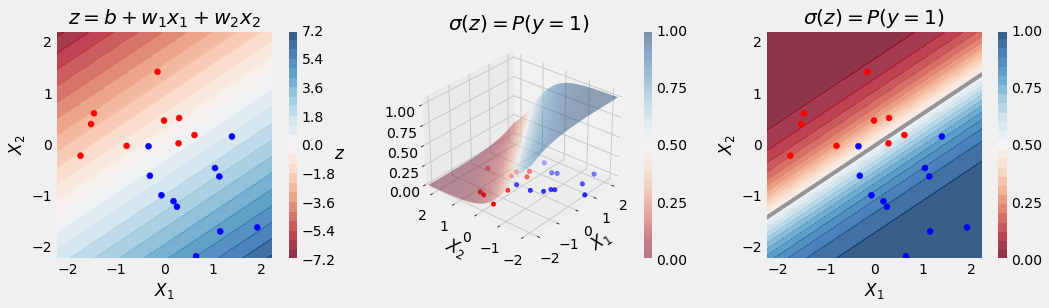

In [49]:
# Validation set
fig = figure7(X_val, y_val, pl_model.model, 'cpu')

See? Apart from three points, two red and one blue, which are _really_ close to the decision boundary, the data points are correctly classified. **More separable, indeed**.

### Are my data points separable?

That's the million-dollar question! In the example above, we can clearly see that data points in the validation set are **more separable** than those in the training set.

What happens if the points are **not separable at all**? Let's take a quick detour and look at another tiny dataset with 10 data points, seven red, three blue. The colors are the **labels (_y_)**, and each data point has a **single feature (_x~1~_)**. We could plot them **along a line**; after all, we have only **one dimension**.

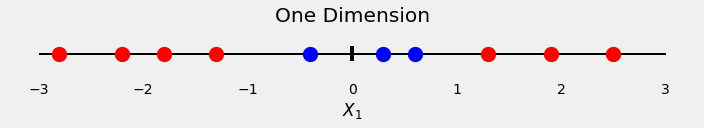

In [50]:
x = np.array([-2.8, -2.2, -1.8, -1.3, -.4, 0.3, 0.6, 1.3, 1.9, 2.5])
y = np.array([0., 0., 0., 0., 1., 1., 1., 0., 0., 0.])

fig = one_dimension(x, y)

Can you **separate the blue points from the red ones with one straight line**? Obviously not—these points **are not separable** (in one dimension, that is).

Should we give up, then?

---

"_Never give up, never surrender!_"

[Commander Taggart](https://i.imgflip.com/51toa2.jpg)


---

If it doesn't work in one dimension, try using two! There is just one problem, though: Where does the other dimension come from? We can use a **trick** here: We apply a **function** to the **original dimension (feature)** and use the result as a **second dimension (feature)**. Quite simple, right?

For the tiny dataset at hand, we could try the **square function**:


$$
\Large X_2 = f(X_1)= X_1^2
$$

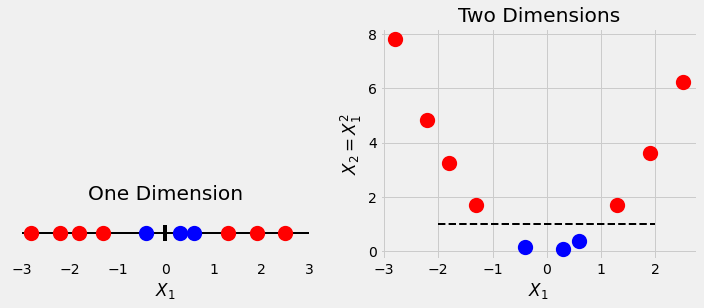

In [51]:
fig = two_dimensions(x, y)

Back to the original question: "_Can you separate the blue points from the red ones with one straight line?_"

In two dimensions, that's a piece of cake!

---

**The more dimensions, the more separable the points are.**

---

It is beyond the scope of this book to explain _why_ this trick works. The important thing is to **understand the general idea**: As the **number of dimensions increases**, there is **more and more empty space**. If the data points are farther apart, it is likely easier to separate them. In two dimensions, the decision boundary is a line. In three dimensions, it is a plane. In four dimensions and more, it is a hyper-plane (fancier wording for a plane you can't draw).

Have you heard of the **kernel trick** for support vector machines (SVMs)? That's pretty much what it does! The **kernel** is nothing but the **function** we use to create additional dimensions. The square function we used is a **polynomial**, so we used a **polynomial kernel**.

"_Why are we talking about SVMs?_"

Excellent question! It turns out **neural networks** may also **increase the dimensionality**. That's what happens if you add a **hidden layer** with **more units** than the **number of features**.

In [53]:
from pytorch_lightning import LightningModule, Trainer, LightningDataModule
from pytorch_lightning.utilities.seed import seed_everything

dummy_x = torch.as_tensor(x).view(-1, 1).float()
dummy_y = torch.as_tensor(y).view(-1, 1).float()

dummy_ds = TensorDataset(dummy_x, dummy_y)
dummy_dl = DataLoader(dummy_ds, batch_size=5, shuffle=True)

AVAIL_GPUS = min(1, torch.cuda.device_count())
seed_everything(42)

#########################
## Model Configuration ##
#########################
lr = 1e-1
dummy_model = nn.Sequential()
dummy_model.add_module('hidden', nn.Linear(1, 2))
dummy_model.add_module('activation', nn.ReLU())
dummy_model.add_module('output', nn.Linear(2, 1))
dummy_model.add_module('sigmoid', nn.Sigmoid())
loss_fn = nn.BCELoss()
pl_dummy_model = PLModel(dummy_model, loss_fn, optim.SGD, lr)

####################
## Model Training ##
####################
!rm -rf ch03/
trainer = Trainer(gpus=AVAIL_GPUS, max_epochs=200, default_root_dir='./ch03')
trainer.fit(pl_dummy_model, train_dataloader=dummy_dl)

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/dvgodoy/anaconda3/envs/torch18/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | model   | Sequential | 7     
1 | loss_fn | BCELoss    | 0     
---------------------------------------
7         Trainable params
0         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
/home/dvgodoy/anaconda3/envs/torch18/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may 

Training: 0it [00:00, ?it/s]

The model above increases dimensionality **from one dimension** (one feature) to **two dimensions** and then uses those **ten dimensions to compute logits**. But it **only works if there is an activation function between the layers**. 

In [54]:
dummy_model(dummy_x), dummy_y

(tensor([[0.1402],
         [0.1402],
         [0.1402],
         [0.2434],
         [0.7376],
         [0.9381],
         [0.8057],
         [0.1638],
         [0.0141],
         [0.0010]], grad_fn=<SigmoidBackward>),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.]]))

In [55]:
out = dummy_model.output.state_dict()
out

OrderedDict([('weight', tensor([[-2.5988,  1.9569]])),
             ('bias', tensor([-1.8140]))])

$$
\Large x_2 = -\frac{b}{w_2} - \frac{w_1}{w_2}x_1
$$

In [56]:
b = (-out['bias']/out['weight'][0][1]).numpy()
w = (-out['weight'][0][0]/out['weight'][0][1]).numpy()
boundary = lambda x: b + w * x
b, w

(array([0.92696804], dtype=float32), array(1.3279978, dtype=float32))

(-0.2, 6.0)

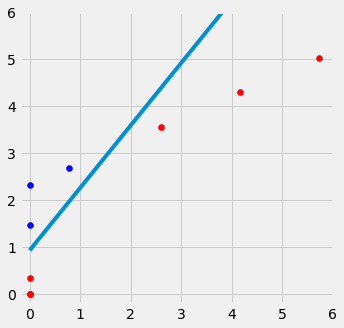

In [57]:
hidden_feat = nn.ReLU()(dummy_model.hidden(dummy_x)).tolist()
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(*np.array(hidden_feat)[y==0].T, c='red')
ax.scatter(*np.array(hidden_feat)[y==1].T, c='blue')
ax.plot([0, 6], [boundary(0), boundary(6)])
ax.set_xlim([-.2, 6])
ax.set_ylim([-.2, 6])

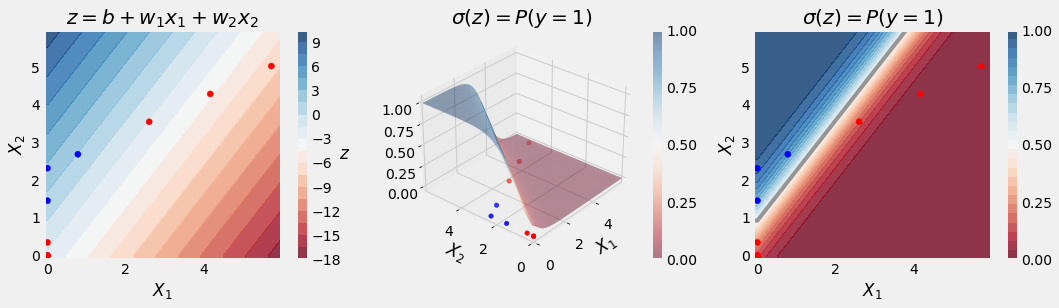

In [59]:
fig = figure7(nn.ReLU()(dummy_model.hidden(dummy_x)).detach(), 
              dummy_y, 
              nn.Sequential(*list(dummy_model.children())[1:-1]), 
              'cpu', x_range=(-.1, 6), y_range=(-.1, 6))

## Classification Threshold

So far, we've been using the trivial threshold of 50% to classify our data points, given the probabilities predicted by our model. Let's dive a bit deeper into this and see the **effects of choosing different thresholds**. We'll be working on the data points in the **validation set**. There are only **20 data points** in it, so we can easily **keep track of all of them**.

First, let's compute the logits and corresponding probabilities:

In [68]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

Then, let's **visualize the probabilities on a line**. It means we're going from the fancy contour plot to a **simpler plot**:

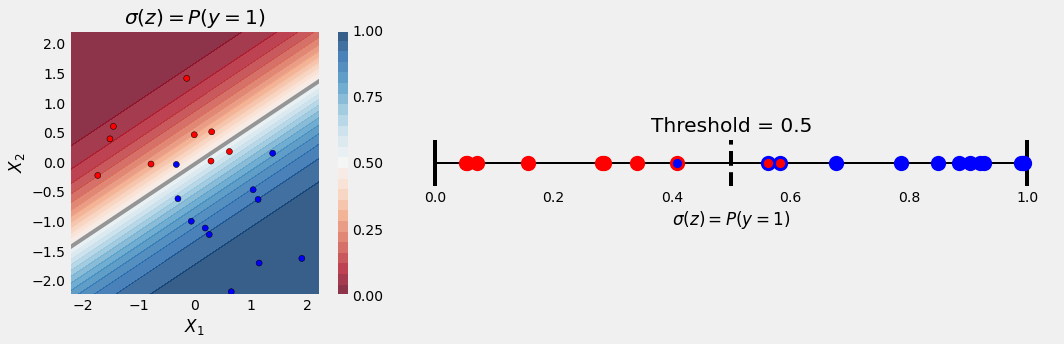

In [69]:
fig = figure9(X_val, y_val, pl_model, 'cpu', probabilities_val, threshold)

The left plot comes from Figure 3.8. It shows the **contour plot of the probabilities** and the **decision boundary as a straight gray line**. We place the data points **on a line**, according to their **predicted probabilities**. That's the plot on the right.

The **decision boundary** is shown as a **vertical dashed line** placed at the **chosen threshold** (0.5). Points to the **left** of the dashed line are **classified as red**, and therefore have **red edges around them**, while those to the **right** are **classified as blue**, and have **blue edges around them**.

The points are **filled with their actual color**, meaning that those with **distinct colors for edge and filling** are **misclassified**. In the figure above, we have **one blue point classified as red (left)** and **two red points classified as blue (right)**.

Now, let's make a _tiny_ change to our plot to make it **more visually interesting**: We'll plot **blue (positive) points below the probability line** and **red (negative) points above the probability line**. 

In [70]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold)

In [1]:
#fig = figure10(y_val, probabilities_val, threshold, 0.04, False)

"_Why is it more visually interesting?_" you ask.

Well, now **all correctly classified** and **all misclassified** points are in **different quadrants**. There is something else that **looks exactly like this**...

### Confusion Matrix

Those quadrants have names: **true negative (TN)** and **false positive (FP)**, above the line, **false negative (FN)** and **true positive (TP)**, below the line.

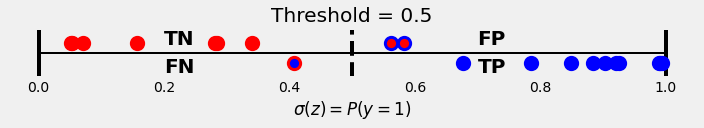

In [74]:
fig = figure10(y_val, probabilities_val, threshold, 0.04, True)

Points **above the line** are **actual negatives**, points **below the line** are **actual positives**.

Points to the **right of the threshold** are **classified as positive**, points to the **left of the threshold** are **classified as negative**.

Cool, right? Let's double-check it with Scikit-Learn's [`confusion_matrix()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method:


In [75]:
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= .5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])

All 20 points in our validation set are accounted for. There are **three misclassified points**: one false negative and two false positives, just like in the figure above. I chose to move the **blue points (positive) below** the line to **match Scikit-Learn's convention for the confusion matrix**.

---

Confusion matrices are already **confusing enough** on their own, but what's even **worse** is that you'll find all sorts of layouts around. Some people list positives first and negatives last. Some people even _flip_ actuals and predicted classes, effectively transposing the confusion matrix. Make sure to always **check the layout** before drawing conclusions from matrices you see "in the wild."

To make your life, and mine, simpler, I am just sticking with Scikit-Learn's convention throughout this book.

---

There is one more thing I hope you noticed already: **The confusion matrix depends on the threshold**. If you **shift the threshold** along the probability line, you'll end up **changing the number of points in each quadrant**.

---

There are **many confusion matrices, one for each threshold**.

---

Moreover, **different confusion matrices** mean **different metrics**. We need the individual components of the confusion matrix, namely, TN, FP, FN, and TP, to construct those metrics. The function below _splits_ the confusion matrix accordingly:

#### True and False Positives and Negatives

In [76]:
def split_cm(cm):
    # Actual negatives go in the top row, 
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row, 
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]
    
    return tn, fp, fn, tp

### Metrics

Starting with these four numbers, TN, FP, FN, and TP, you may construct **a ton of metrics**. We're focusing here on the most commonly used: **true and false positive rates** (TPR and FPR), **precision**, **recall**, and **accuracy**.

### True and False Positive Rates

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

For both of them, you **divide one value on the right column (positive)** by the **sum of the corresponding row**. So, the **true positive rate** is computed by dividing the value on the **bottom right** by the sum of the **bottom row**. Similarly, the **false positive rate** is computed by dividing the value on the **top right** by the sum of the **top row**. Fine, but what do they mean?

The **true positive rate** tells you, from **all points you _know_ to be positive, how many your model got right**. In our example, we **know** there are **11 positive** examples. Our model **got ten right**. The **TPR** is 10 out of 11, or roughly 91%. There is yet another name for this metric: **recall**. Makes sense, right? From all the positive examples, how many does your model **recall**?

---

If **false negatives** are bad for your application, you need to **focus on improving the TPR (recall)** metric of your model.

---

When is a false negative _really_ bad? Take airport security screening, for example, where **positive means the existence of a threat**. False positives are common: You have nothing to hide, and still, your bag will eventually be more thoroughly inspected due to the extreme sensitivity of the machinery. A **false negative** means that the machine **failed to detect an actual threat**. I don't have to explain why this is **bad**.

The **false positive rate** tells you, from **all points you _know_ to be negative, how many your model got wrong**. In our example, we **know** there are **nine negative** examples. Our model **got two wrong**. The **FPR** is 2 out of 9, or roughly 22%.

---

If **false positives** are bad for your application, you need to **focus on reducing the FPR** metric of your model.

---

When is a false positive _really_ bad? Take an investment decision, for example, where **positive means a profitable investment**. False negatives are missed opportunities: They seemed like bad investments, but they weren't. You did not make a profit, but you didn't sustain any losses either. A **false positive** means that you chose to invest but ended up **losing your money**.

We can use the function below to compute both metrics, given a confusion matrix:


In [80]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    
    return tpr, fpr

In [81]:
tpr_fpr(cm_thresh50)

(0.9090909090909091, 0.2222222222222222)

## The trade-off between TPR and FPR

****
As always, there is a _trade-off_ between the two metrics. 

Let's say **false negatives** are bad for our application, and we want to **improve TPR**. Here is one quick idea: Let's make a model that **only predicts the positive class**, using a **threshold of zero**. We get **no false negatives whatsoever** (because there aren't any negatives in the first place). Our **TPR is 100%**. Awesome, right? 

Wrong! If all points are predicted to be positive, **every negative example will be a false positive, and there are no true negatives**. Our **FPR is 100% too**. 

There is no free lunch: The model is useless.

What if **false positives** are the problem instead? We would like to **reduce FPR**. Another _brilliant_ idea comes to mind: Let's make a model that **only predicts the negative class**, using a **threshold of one**. We get **no false positives whatsoever** (because there aren't any positives in the first place). Our **FPR is 0%**. Mission accomplished, right?

Guess what? Wrong again! If all points are predicted to be negative, **every positive example will be a false negative, and there are no true positives**. Our **TPR is 0% too**. 

It turns out, you cannot have the cake and eat it too.
****


### Precision and Recall

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

We can _skip_ the **recall** because, as I mentioned above, it is the **same as TPR**: from all the positive examples, how many does your model **recall**?

What about **precision**? We compute it in the **right column (positive) only**. We divide the value on the **bottom right** by the sum of the **right column**. Its meaning is somewhat complementary to that of recall: From **all points classified as positive by _your model_, how many did it get right?** In our example, the **model classified 12 points as positive**. The model **got 10 right**. The **precision** is 10 out of 12, or roughly 83%.

---

If **false positives** are bad for your application, you need to **focus on improving the precision** metric of your model.

---

We can use the function below to compute both metrics, given a confusion matrix:

In [82]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    return precision, recall

In [83]:
precision_recall(cm_thresh50)

(0.8333333333333334, 0.9090909090909091)

## The trade-off between precision and recall

****
Here, too, there is no free lunch. The trade-off is a bit different, though.

Let's say **false negatives** are bad for our application, and we want to **improve recall**. Once again, let's make a model that **only predicts the positive class**, using a **threshold of zero**. We get **no false negatives whatsoever** (because there aren't any negatives in the first place). Our **recall is 100%**. Now you're probably waiting for the bad news, right? 

If all points are predicted to be positive, **every negative example will be a false positive**. The **precision** is exactly the **proportion of positive samples in the dataset**.

What if **false positives** are the problem instead? We would like to **increase precision**. It's time to make a model that **only predicts the negative class** by using a **threshold of one**. We get **no false positives whatsoever** (because there aren't any positives in the first place). Our **precision is 100%**. 

Of course, this is too good to be true. If all points are predicted to be negative, **there are no true positives**. Our **recall is 0%**.

No free lunch, no cake, just another couple of useless models.
****

There is one metric left to explore.

### Accuracy

This is the simplest and most intuitive of them all: how many times your model got it right, considering all data points. Totally straightforward!

$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

In our example, the model got 17 points right out of a total of 20 data points. Its accuracy is 85%. Not bad, right? The higher the accuracy, the better, but it does not tell the whole story. If you have an imbalanced dataset, relying on accuracy can be misleading.

Let's say we have 1,000 data points: 990 points are negative, and only 10 are positive. Now, let's take that model that uses a threshold of one and **only predicts the negative class**. This way, we get **all 990 negative points right** at the cost of **ten false negatives**. This model's accuracy is **99%**. But the model is still useless because it will _never_ get a positive example right.

Accuracy may be misleading because it does not involve a trade-off with another metric, like the previous ones.

Speaking of trade-offs...

## Trade-offs and Curves

We already know there are trade-offs between true and false positive rates, as well as between precision and recall. We also know that there are many confusion matrices, one for each threshold. What if we combine these two pieces of information? I present to you the **receiver operating characteristic (ROC)** and **precision-recall (PR)** curves! Well, they are not curves _yet_, but they will be soon enough!

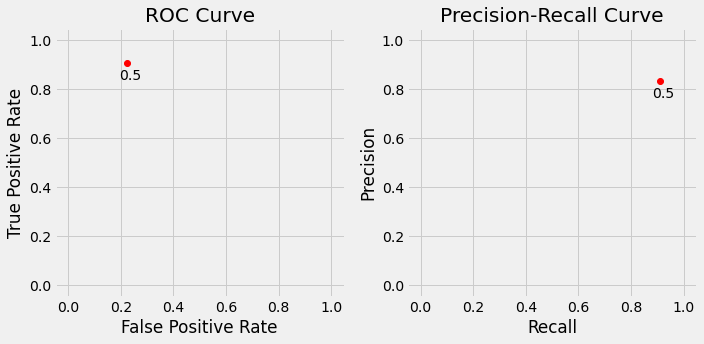

In [130]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.5], annot=True)

We've already computed TPR (recall) (91%), FPR (22%), and precision (83%) for our model using the threshold of 50%. If we plot them, we'll get the figure above.

Time to try **different thresholds**. 

### Low Threshold

What about 30%? If the predicted probability is greater than or equal to 30%, we classify the data point as positive, and as negative otherwise. That's a very **loose** threshold since we don't require the model to be very confident to consider a data point to be positive. What can we expect from it? **More false positives, fewer false negatives**.

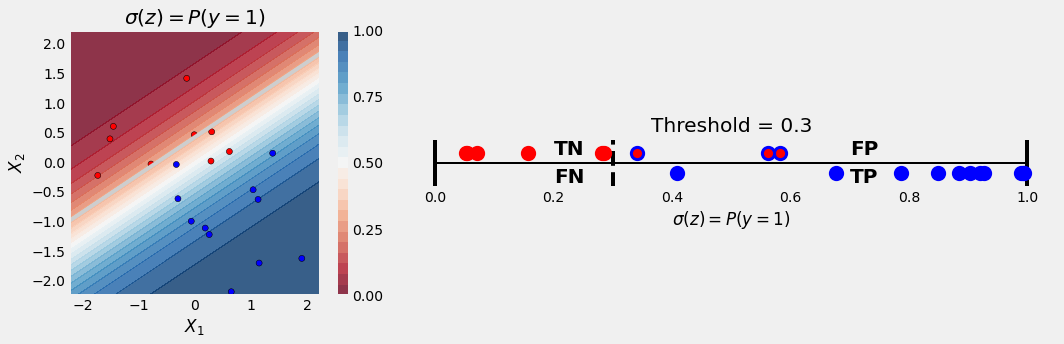

In [131]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.3, shift=0.04, annot=True)

You can see in the figure above that **lowering the threshold** (moving it to the left on the probability line) **turned one false negative into a true positive** (blue point close to 0.4), but it also **turned one true negative into a false positive** (red point close to 0.4).

Let's double-check it with Scikit-Learn's confusion matrix:

In [132]:
confusion_matrix(y_val, (probabilities_val >= 0.3))

array([[ 6,  3],
       [ 0, 11]])

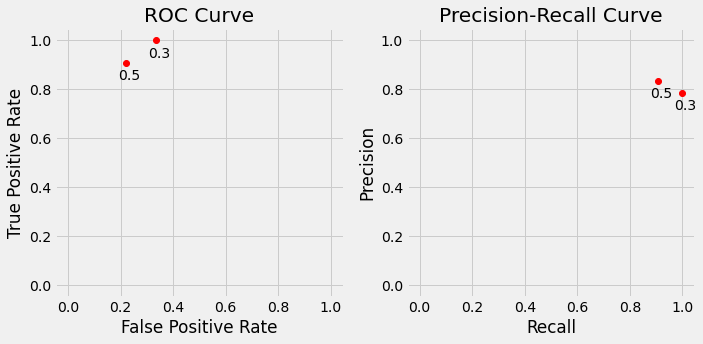

In [133]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5], annot=True)

Still not a curve, I know, but we can already learn something from these two points.

**Lowering the threshold moves you to the right along both curves.**

Let's move to the other side now.

### High Threshold

What about 70%? If the predicted probability is greater than or equal to 70%, we classify the data point as positive, and as negative otherwise. That's a very **strict** threshold since we require the model to be very confident to consider a data point to be positive. What can we expect from it? **Fewer false positives, more false negatives**.

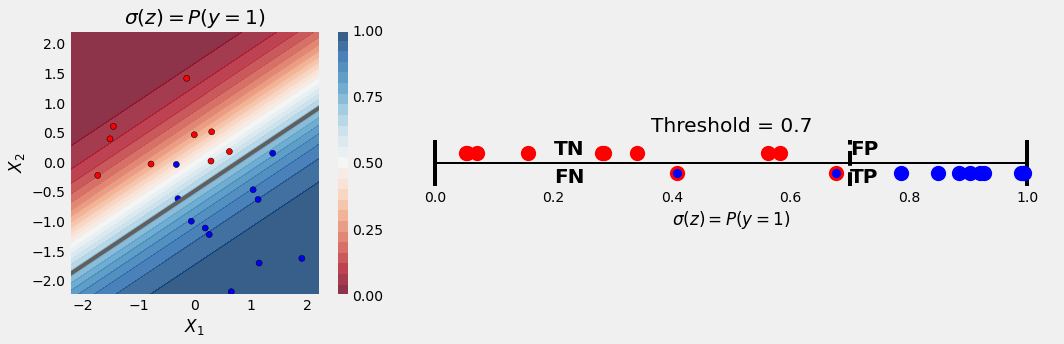

In [134]:
fig = figure9(X_val, y_val, sbs.model, sbs.device, probabilities_val, threshold=0.7, shift=0.04, annot=True)

You can see in the figure above that **raising the threshold** (moving it to the right on the probability line) **turned two false positives into true negatives** (red points close to 0.6), but it also **turned one true positive into a false negative** (blue point close to 0.6).

Let's double-check it with Scikit-Learn's confusion matrix:

In [135]:
confusion_matrix(y_val, (probabilities_val >= 0.7))

array([[9, 0],
       [2, 9]])

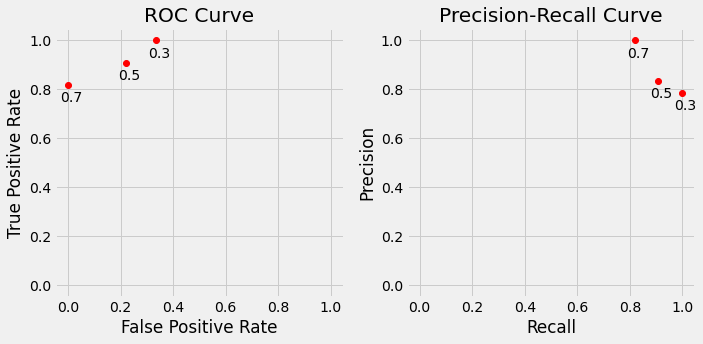

In [136]:
fig = eval_curves_from_probs(y_val, probabilities_val, [.3, .5, .7], annot=True)

I guess we earned the right to call it a curve now :-)

**Raising the threshold moves you to the left along both curves.**

Can we just _connect the dots_ and call it a curve for real? Actually, no, not yet.

### ROC and PR Curves

We need to try out **more thresholds** to actually build a curve. Let's try multiples of 10%:

In [137]:
threshs = np.linspace(0.,1,11)

/home/dvgodoy/projects/PyTorch101_Live/plots/chapter3.py:49: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp + fp)


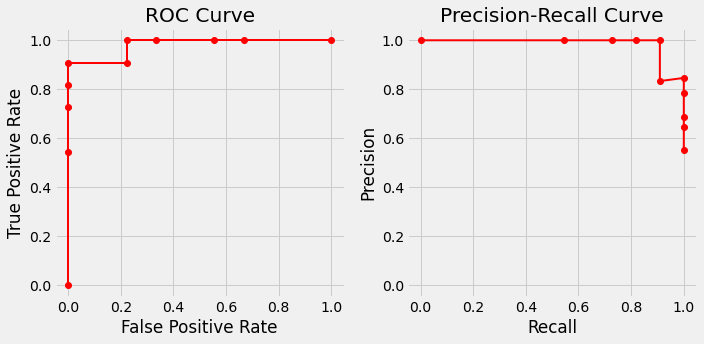

In [138]:
fig = figure17(y_val, probabilities_val, threshs)

Cool! We finally have proper curves! I have some questions for you:

- In each plot, which point corresponds to a **threshold of zero (every prediction is positive)**?
- In each plot, which point corresponds to a **threshold of one (every prediction is negative)**?
- What does the **right-most point in the PR curve** represent?
- If I **raise the threshold**, how do I **move along the curve**?

You should be able to answer all of these questions by referring to the "Metrics" section. But, if you are eager to get the answers, here they are:

- The **threshold of zero** corresponds to the **right-most** point in both curves.
- The **threshold of one** corresponds to the **left-most** point in both curves.
- The **right-most point in the PR curve** represents the **proportion of positive examples in the dataset**.
- If I **raise the threshold**, I am **moving to the left** along both curves.

Now, let's double-check our curves with Scikit-Learn's [`roc_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and [`precision_recall_curve()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) methods:

In [139]:
fpr, tpr, thresholds1 = roc_curve(y_val, probabilities_val)
prec, rec, thresholds2 = precision_recall_curve(y_val, probabilities_val)

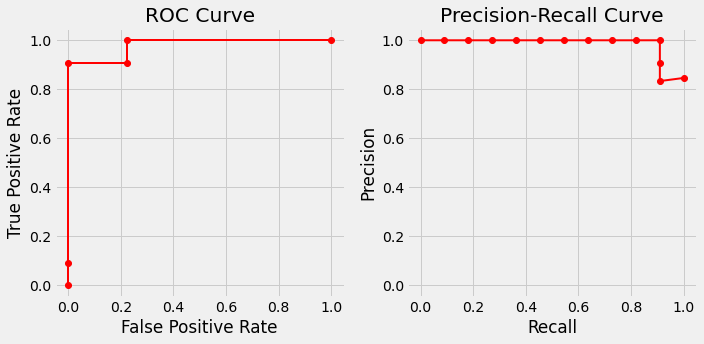

In [140]:
fig = eval_curves(fpr, tpr, rec, prec, thresholds1, thresholds2, line=True)

Same shapes, different points.

"_Why do these curves have **different points** than ours?_"

Simply put, Scikit-Learn uses only **meaningful thresholds**; that is, those thresholds that **actually make a difference to the metrics**. If moving the threshold a bit does not modify the classification of any points, it doesn't matter for building a curve. Also, notice that the **two curves** have a **different number of points** because different metrics have different sets of meaningful thresholds. Moreover, these **thresholds do not necessarily include the extremes: zero and one**. In Scikit-Learn's PR curve, the right-most point is clearly different than ours.

"_How come the PR curve **dips to lower precision**? Shouldn't it always go up as we raise the threshold, moving to the left along the curve?_"

### The Precision Quirk

Glad you asked! This is very annoying and somewhat counterintuitive, but it happens often, so let's take a closer look at it. To illustrate **why this happens**, I will plot the probability lines for three distinct thresholds: 0.4, 0.5, and 0.57.

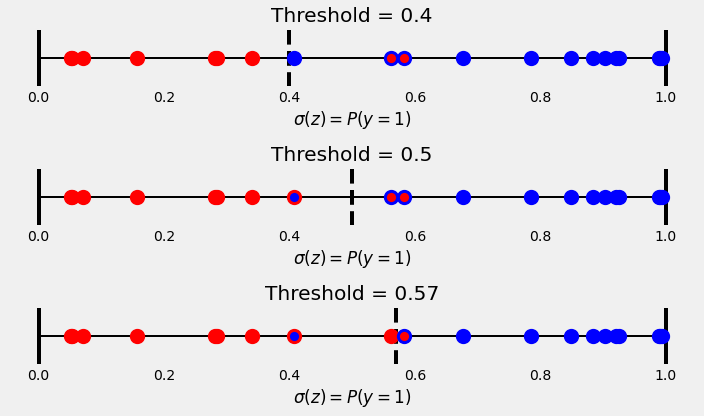

In [141]:
fig = figure19(y_val, probabilities_val)

At the top, with a threshold of 0.4, we have **15 points** on the right (classified as **positive**), **two of which are false positives**. The **precision** is given by:

$$
\Large \text{Precision}(\text{thresh}=0.40)=\frac{13}{13+2}=0.8666
$$

But if we move the threshold to the right, up to 0.5, we **lose one true positive**, effectively **reducing precision**:

$$
\Large \text{Precision}(\text{thresh}=0.50)=\frac{(13-1)}{(13-1)+2}=\frac{12}{12+2}=0.8571
$$

This is a **temporary side effect**, though. As we raise the threshold even further to 0.57, we get the benefit of **getting rid of a false positive**, thus **increasing precision**:


$$
\Large \text{Precision}(\text{thresh}=0.57)=\frac{12}{12+(2-1)}=\frac{12}{12+1}=0.9230
$$

In general, **raising the threshold** will **reduce the number of false positives** and **increase precision**. 

But, along the way, we **may lose some of the true positives**, which will **temporarily reduce precision**. _Quirky_, right?

### Best and Worst Curves

Let's ask ourselves: What would the **best possible** (and, of course, the **worst possible**) curve look like?

The **best** curve belongs to a model that predicts everything perfectly: It gives us a 100% probability to all actual positive data points and 0% probability to all actual negative data points. Of course, such a model _does not exist_ in real life. But _cheating_ does exist. So, let's cheat and use the **true labels** as the **probabilities**. These are the curves we get:

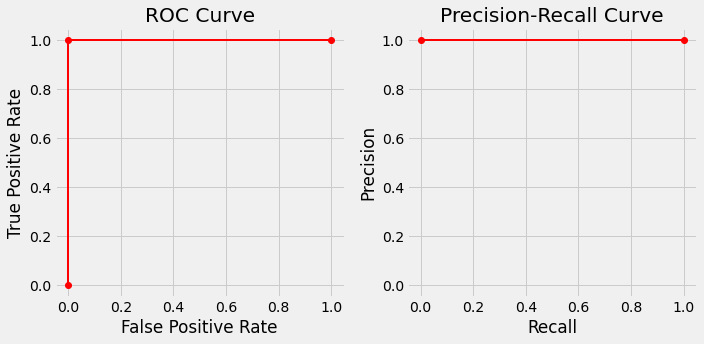

In [142]:
# Best
fig = figure20(y_val)

Nice! If a perfect model exists, its curves are actually *squares*! The **top-left corner** on the **ROC curve**, as well as the **top-right corner** on the **PR curve**, are the (unattainable) sweet spots. Our logistic regression was _not bad_, actually—but, of course, our validation set was ridiculously easy.

"_And the Oscar for the **worst curve** goes to..._"

"_...the **random model**!_"

If a model spits out **probabilities all over the place**, without any regard to the actual data, it is as bad as it can be. We can simply **generate uniformly distributed values between zero and one** as our **random probabilities**:


In [143]:
np.random.seed(39)
random_probs = np.random.uniform(size=y_val.shape)

In [144]:
fpr_random, tpr_random, thresholds1_random = roc_curve(y_val, random_probs)
prec_random, rec_random, thresholds2_random = precision_recall_curve(y_val, random_probs)

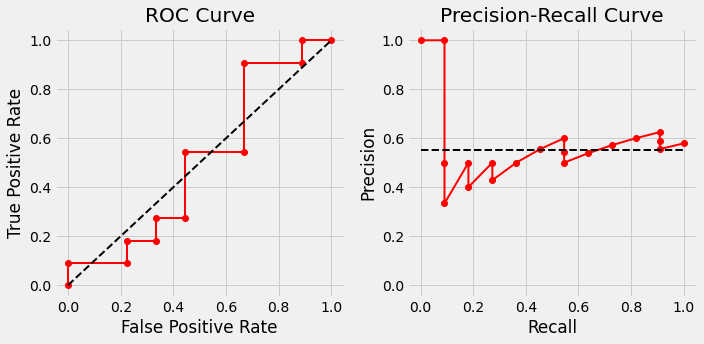

In [145]:
# Worst
fig = figure21(y_val, random_probs)

We have only 20 data points, so our curves are not **as bad as they theoretically are** :-) The black dashed lines are the _theoretical worst_ for both curves. On the left, the **diagonal line** is as bad as it can be. On the right, it is a _bit_ more nuanced: The **worst is a horizontal line**, but the **level** is given by the **proportion of positive samples** in the dataset. In our example, we have 11 positive examples out of 20 data points, so the line sits at the level of 0.55.

### Comparing Models

"_If I have two models, how do I choose the best one?_"

"_The best model is the one with the best curve._"

[Captain Obvious](https://i.imgflip.com/4a7fct.jpg)

Thank you, Captain. The real question here is: How do you compare curves? The **closer** they are to **squares**, the **better** they are, this much we already know. Besides, if **one curve has all its points above all the points of another curve**, the one above is clearly the best. The problem is, two different models may produce curves that **intersect each other** at some point. If that's the case, **there is no clear winner**.

One possible solution to this dilemma is to look at the **area under the curve**. The curve with **more area** under it **wins**! Luckily, Scikit-Learn has an [`auc()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)  (**a**rea **u**nder the **c**urve) method, which we can use to compute the area under the curves for our (good) model:


In [146]:
# Area under the curves of our model
auroc = auc(fpr, tpr)
aupr = auc(rec, prec)
print(auroc, aupr)

0.9797979797979798 0.9854312354312356


Very close to the perfect value of one! But then again, this is a test example—you shouldn't expect figures so high in real-life problems. What about the random model? The theoretical minimum for the **area under the worst ROC curve is 0.5**, which is the area under the diagonal. The theoretical minimum for the **area under the worst PR curve is the proportion of positive samples in the dataset**, which is 0.55 in our case.


In [147]:
# Area under the curves of the random model
auroc_random = auc(fpr_random, tpr_random)
aupr_random = auc(rec_random, prec_random)
print(auroc_random, aupr_random)

0.505050505050505 0.570559046216941


Close enough; after all, the curves produced by our random model were only roughly approximating the theoretical ones.

If you want to learn more about both curves, you can check Scikit-Learn's documentation for https://bit.ly/34lPAlx["Receiver Operating Characteristic (ROC)"]footnote:[https://bit.ly/34lPAlx] and https://bit.ly/30xB9JZ["Precision-Recall"]footnote:[https://bit.ly/30xB9JZ]. Another good resource is Jason Brownlee's Machine Learning Mastery blog: https://bit.ly/30vF7TE["How to Use ROC Curves and Precision-Recall Curves for Classification in Python"]footnote:[https://bit.ly/30vF7TE] and https://bit.ly/2GCEL6A["ROC Curves and Precision-Recall Curves for Imbalanced Classification"]footnote:[https://bit.ly/2GCEL6A].


## Putting It All Together

In [68]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=16, 
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [69]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

In [70]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

In [71]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1822, -1.8684]], device='cuda:0')), ('linear.bias', tensor([-0.0587], device='cuda:0'))])


In [72]:
logits_val = sbs.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[ 7,  2],
       [ 1, 10]])